In [1]:
import os
import cv2
import glob
import json
import torch
import tifffile
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
class ClassificationDataset(Dataset):

    def __init__(self, root_dir, mask_type='random', augment=False, target_size=None):
        self.root_dir = root_dir
        self.mask_type = mask_type
        self.augment = augment
        self.target_size = target_size
       
        
        # Band names in order (12 bands total)
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        
        self.band_resolutions = {
            'B1': 60, 'B2': 10, 'B3': 10, 'B4': 10,
            'B5': 20, 'B6': 20, 'B7': 20, 'B8': 10,
            'B8A': 20, 'B9': 60, 'B11': 20, 'B12': 20
        }
        
        self.samples = []
        for region_folder in tqdm(glob.glob(os.path.join(root_dir, '*'))):
            if os.path.isdir(region_folder):
                if(region_folder[-3:] == "RPH"): label = "RPH"
                elif(region_folder[-5:] == "Blast"): label = "Blast"
                elif(region_folder[-4:] == "Rust"): label = "Rust"
                elif(region_folder[-5:] == "Aphid"): label = "Aphid"
                else: continue

                for timestamp_folder in glob.glob(os.path.join(region_folder, '*')):
                    if os.path.isdir(timestamp_folder):
                        # Check if all bands exist
                        band_paths = {band: os.path.join(timestamp_folder, f'{band}.tif') 
                                     for band in self.bands}
                        if all(os.path.exists(p) for p in band_paths.values()):
                            self.samples.append((band_paths,label))
        
        print(f"Found {len(self.samples)} samples with all 12 bands")
    
    def __len__(self):
        return len(self.samples)
    def resize_band(self, band_data, target_shape):
        if band_data.shape == target_shape:
            return band_data
        
        resized = cv2.resize(
            band_data, 
            (target_shape[1], target_shape[0]),  # OpenCV uses (W, H)
            interpolation=cv2.INTER_LINEAR
        )
        return resized
    def load_multispectral_image(self, band_paths):
        bands_data = []
        shapes = []
        
        loaded_bands = {}
        for band in self.bands:
            img = tifffile.imread(band_paths[band])
            loaded_bands[band] = img
            shapes.append(img.shape)
        
        if self.target_size is not None:
            target_shape = self.target_size
        else:
            reference_band = loaded_bands['B4']  # 10m band
            target_shape = reference_band.shape
        
        # Second pass: resize all bands to target shape
        for band in self.bands:
            img = loaded_bands[band]
            
            # Resize if needed
            if img.shape != target_shape:
                img = self.resize_band(img, target_shape)
            
            bands_data.append(img)
        
        # Stack along channel dimension: (12, H, W)
        multi_band = np.stack(bands_data, axis=0)
        return multi_band 
    def normalize_sentinel2(self, img):
        """
        Normalize Sentinel-2 data to [0, 1]
        Sentinel-2 L1C has typical range 0-10000 (reflectance * 10000)
        """
        # Clip extreme values and normalize
        img = np.clip(img, 0, 10000)
        img = img.astype(np.float32) / 10000.0
        return img  
    def normalize_satlas(self,img):
        img = np.clip(img, 0, 8160)
        img = img.astype(np.float32) / 8160
        return img
    def create_random_mask(self, shape, num_masks=None):
        """Create random rectangular mask(s)"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)
        
        if num_masks is None:
            num_masks = np.random.randint(1, 4)
        
        for _ in range(num_masks):
            mask_h = np.random.randint(32, min(128, H // 2))
            mask_w = np.random.randint(32, min(128, W // 2))
            
            top = np.random.randint(0, H - mask_h)
            left = np.random.randint(0, W - mask_w)
            
            # Mask all channels
            mask[:, top:top+mask_h, left:left+mask_w] = 0
        
        return mask 
    def create_center_mask(self, shape, mask_ratio=0.25):
        """Create centered square mask"""
        C, H, W = shape
        mask = np.ones((C, H, W), dtype=np.float32)
        
        mask_size = int(min(H, W) * mask_ratio)
        top = (H - mask_size) // 2
        left = (W - mask_size) // 2
        
        mask[:, top:top+mask_size, left:left+mask_size] = 0
        return mask 
    def augment_data(self, img):
        """Random flips and rotations"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=2).copy()
        
        # Random vertical flip
        if np.random.random() > 0.5:
            img = np.flip(img, axis=1).copy()
        
        # Random 90 degree rotations
        k = np.random.randint(0, 4)
        if k > 0:
            img = np.rot90(img, k, axes=(1, 2)).copy()
        
        return img
    
    def __getitem__(self, idx):

        band_paths,label = self.samples[idx]
        img = self.load_multispectral_image(band_paths)
        img = self.normalize_satlas(img)
        if(label == "RPH"): label = 0
        elif(label == "Blast"): label = 1
        elif(label == "Rust"): label = 2
        elif(label == "Aphid"): label = 3
        self.bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
        c9 = img[(3,2,1,4,5,6,7,10,11),:,:]
        c12 = img
        return {
            'c9': c9,      
            'c12': c12,
            'label': label
        }
        

In [3]:
import numpy as np
from torch.utils.data import Subset, DataLoader


def create_balanced_split(dataset, val_samples_per_class=20, max_train_per_class=100):
    """
    Create balanced train/val split with fixed number of samples per class
    
    Args:
        dataset: Your ClassificationDataset
        val_samples_per_class: Number of samples per class for validation
        max_train_per_class: Maximum number of samples per class for training
    
    Returns:
        train_indices, val_indices
    """
    # Get all labels
    all_labels = []
    for idx in range(len(dataset)):
        sample = dataset[idx]
        all_labels.append(sample['label'])
    
    all_labels = np.array(all_labels)
    
    # Get indices for each class
    class_indices = {
        0: np.where(all_labels == 0)[0],  # RPH
        1: np.where(all_labels == 1)[0],  # Blast
        2: np.where(all_labels == 2)[0],  # Rust
        3: np.where(all_labels == 3)[0],  # Aphid
    }
    
    # Print original class distribution
    print("Original class distribution:")
    class_names = ['RPH', 'Blast', 'Rust', 'Aphid']
    for cls_id, indices in class_indices.items():
        print(f"  {class_names[cls_id]}: {len(indices)} samples")
    
    train_indices = []
    val_indices = []
    
    print(f"\nSplitting with {val_samples_per_class} val and max {max_train_per_class} train per class:")
    
    # For each class, split into train/val
    for cls_id, indices in class_indices.items():
        # Shuffle indices for this class
        np.random.seed(42)  # For reproducibility
        shuffled = indices.copy()
        np.random.shuffle(shuffled)
        
        # Take first val_samples_per_class for validation
        val_idx = shuffled[:val_samples_per_class]
        
        # Take next max_train_per_class for training (limit to max)
        remaining = shuffled[val_samples_per_class:]
        train_idx = remaining[:max_train_per_class]
        
        # Calculate how many were left out
        left_out = len(remaining) - len(train_idx)
        
        val_indices.extend(val_idx)
        train_indices.extend(train_idx)
        
        print(f"  {class_names[cls_id]}: {len(train_idx)} train, {len(val_idx)} val, {left_out} left out")
    
    # Shuffle the final indices
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)
    
    print(f"\nFinal counts:")
    print(f"  Training: {len(train_indices)} samples")
    print(f"  Validation: {len(val_indices)} samples")
    print(f"  Total used: {len(train_indices) + len(val_indices)} / {len(dataset)}")
    
    return train_indices, val_indices


# Create dataset
cdata = ClassificationDataset(
    root_dir="C:\\Users\\ayush\\OneDrive\\Desktop\\Agriculture\\ICPR02\\kaggle",
    mask_type='random',
    augment=True,
    target_size=(256, 256)
)

# Create balanced split with limits
train_indices, val_indices = create_balanced_split(
    cdata, 
    val_samples_per_class=20,
    max_train_per_class=100  # Limit to 100 training samples per class
)

# Create Subset datasets
train_dataset = Subset(cdata, train_indices)
val_dataset = Subset(cdata, val_indices)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
)

print(f"\nDataLoaders created successfully!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


100%|██████████| 5/5 [00:00<00:00, 10.29it/s]


Found 900 samples with all 12 bands
Original class distribution:
  RPH: 495 samples
  Blast: 75 samples
  Rust: 40 samples
  Aphid: 290 samples

Splitting with 20 val and max 100 train per class:
  RPH: 100 train, 20 val, 375 left out
  Blast: 55 train, 20 val, 0 left out
  Rust: 20 train, 20 val, 0 left out
  Aphid: 100 train, 20 val, 170 left out

Final counts:
  Training: 275 samples
  Validation: 80 samples
  Total used: 355 / 900

DataLoaders created successfully!
Train batches: 18
Val batches: 5


# 12 Channels

In [ ]:
from satlasswin import SatlasSwin

In [8]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder_path = None, *args, **kwargs ,):
        super().__init__(*args, **kwargs)
        self.encoder = SatlasSwin(channels=12)

        for param in self.encoder.parameters():
            param.requires_grad = False
            
        first_conv = self.encoder.enc.backbone.backbone.features[0][0]
        for param in first_conv.parameters():
            param.requires_grad = True
            
        self.encoder.eval()

        self.stack = nn.Sequential(
                        nn.Conv2d(1024,256,kernel_size=1,stride=1),
                        nn.LeakyReLU(),
                        nn.Flatten(),
                        nn.Linear(256 * 8 * 8,256 * 8),
                        nn.LeakyReLU(),
                        nn.Linear(256 * 8,256),
                        nn.LeakyReLU(),
                        nn.Linear(256,64),
                        nn.LeakyReLU(),
                        nn.Linear(64,4),
        )

    def forward(self,x):
        x = self.encoder(x)
        x = x[3]
        return self.stack(x)
    

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

def train_classification_model(
    model,
    train_loader,
    val_loader,
    num_epochs=50,
    learning_rate=1e-3,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    save_dir='satlas_baseline_classification_checkpoints12'
):
    os.makedirs(save_dir, exist_ok=True)
    
    # Move model to device
    model = model.to(device)
    
    # Freeze encoder (optional - remove these lines if you want to fine-tune)
    for param in model.encoder.parameters():
        param.requires_grad = False
    
    # Loss and optimizer
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)
    
    # Tracking
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_val_acc = 0.0
    
    print(f"Training on {device}")
    print(f"Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    
    model.train()
    model.encoder.eval()
    for epoch in range(num_epochs):
        # ================== TRAINING ==================
        # Keep encoder in eval mode if frozen
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch in pbar:
            images = batch['c12'].to(device)
            labels = batch['label'].to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100. * correct / total:.2f}%'
            })
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch in pbar:
                images = batch['c12'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{100. * val_correct / val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Print epoch summary
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%')
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'train_acc': train_acc,
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, os.path.join(save_dir, 'best_classifier.pth'))
            print(f'  ✓ Saved best model with val_acc = {val_acc:.2f}%')
        
        # Save checkpoint every 10 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))
        
        print('-' * 60)
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(train_accs, label='Train Acc', marker='o')
    ax2.plot(val_accs, label='Val Acc', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_curves.png'), dpi=150)
    plt.show()
    
    print(f'\n🎉 Training complete!')
    print(f'Best validation accuracy: {best_val_acc:.2f}%')
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

Total parameters: 122,309,412
Trainable parameters: 34,384,836
Frozen parameters: 87,924,576
Training on cuda
Total trainable parameters: 34,360,132


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  3.07it/s, loss=1.6844, acc=38.75%]



Epoch 1/50:
  Train Loss: 1.2516 | Train Acc: 40.00%
  Val Loss:   1.6629 | Val Acc:   38.75%
  ✓ Saved best model with val_acc = 38.75%
------------------------------------------------------------


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s, loss=1.5508, acc=43.75%]



Epoch 2/50:
  Train Loss: 1.1156 | Train Acc: 57.09%
  Val Loss:   1.2879 | Val Acc:   43.75%
  ✓ Saved best model with val_acc = 43.75%
------------------------------------------------------------


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.79it/s, loss=1.1466, acc=50.00%]



Epoch 3/50:
  Train Loss: 0.9252 | Train Acc: 60.00%
  Val Loss:   1.0027 | Val Acc:   50.00%
  ✓ Saved best model with val_acc = 50.00%
------------------------------------------------------------


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s, loss=0.8182, acc=58.75%]



Epoch 4/50:
  Train Loss: 0.8094 | Train Acc: 66.55%
  Val Loss:   0.7750 | Val Acc:   58.75%
  ✓ Saved best model with val_acc = 58.75%
------------------------------------------------------------


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.72it/s, loss=1.0723, acc=61.25%]



Epoch 5/50:
  Train Loss: 0.6601 | Train Acc: 71.64%
  Val Loss:   0.8636 | Val Acc:   61.25%
  ✓ Saved best model with val_acc = 61.25%
------------------------------------------------------------


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s, loss=1.1780, acc=55.00%]



Epoch 6/50:
  Train Loss: 0.5802 | Train Acc: 73.09%
  Val Loss:   0.9528 | Val Acc:   55.00%
------------------------------------------------------------


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.78it/s, loss=1.0111, acc=58.75%]



Epoch 7/50:
  Train Loss: 0.5133 | Train Acc: 81.45%
  Val Loss:   0.8022 | Val Acc:   58.75%
------------------------------------------------------------


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s, loss=1.4050, acc=57.50%]



Epoch 8/50:
  Train Loss: 0.4579 | Train Acc: 74.55%
  Val Loss:   0.9649 | Val Acc:   57.50%
------------------------------------------------------------


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, loss=0.9428, acc=66.25%]



Epoch 9/50:
  Train Loss: 0.3231 | Train Acc: 85.82%
  Val Loss:   0.8772 | Val Acc:   66.25%
  ✓ Saved best model with val_acc = 66.25%
------------------------------------------------------------


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=0.8970, acc=68.75%]



Epoch 10/50:
  Train Loss: 0.2762 | Train Acc: 88.00%
  Val Loss:   0.7344 | Val Acc:   68.75%
  ✓ Saved best model with val_acc = 68.75%
------------------------------------------------------------


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.73it/s, loss=0.7866, acc=70.00%]



Epoch 11/50:
  Train Loss: 0.2235 | Train Acc: 90.91%
  Val Loss:   0.7808 | Val Acc:   70.00%
  ✓ Saved best model with val_acc = 70.00%
------------------------------------------------------------


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.65it/s, loss=1.4960, acc=67.50%]



Epoch 12/50:
  Train Loss: 0.1701 | Train Acc: 93.09%
  Val Loss:   0.8474 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s, loss=1.3101, acc=71.25%]



Epoch 13/50:
  Train Loss: 0.1364 | Train Acc: 95.27%
  Val Loss:   1.0249 | Val Acc:   71.25%
  ✓ Saved best model with val_acc = 71.25%
------------------------------------------------------------


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s, loss=0.8519, acc=71.25%]



Epoch 14/50:
  Train Loss: 0.1669 | Train Acc: 95.27%
  Val Loss:   0.7142 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s, loss=1.3486, acc=71.25%]



Epoch 15/50:
  Train Loss: 0.0890 | Train Acc: 97.82%
  Val Loss:   0.9732 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s, loss=3.4115, acc=67.50%]



Epoch 16/50:
  Train Loss: 0.0438 | Train Acc: 99.27%
  Val Loss:   1.9735 | Val Acc:   67.50%
------------------------------------------------------------


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s, loss=1.2034, acc=65.00%]



Epoch 17/50:
  Train Loss: 0.1071 | Train Acc: 97.09%
  Val Loss:   1.0208 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.92it/s, loss=0.7384, acc=75.00%]



Epoch 18/50:
  Train Loss: 0.0612 | Train Acc: 98.55%
  Val Loss:   0.7314 | Val Acc:   75.00%
  ✓ Saved best model with val_acc = 75.00%
------------------------------------------------------------


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s, loss=1.8947, acc=65.00%]



Epoch 19/50:
  Train Loss: 0.0268 | Train Acc: 99.27%
  Val Loss:   1.3838 | Val Acc:   65.00%
------------------------------------------------------------


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s, loss=1.4443, acc=68.75%]



Epoch 20/50:
  Train Loss: 0.0152 | Train Acc: 99.64%
  Val Loss:   1.1059 | Val Acc:   68.75%
------------------------------------------------------------


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.66it/s, loss=1.3926, acc=71.25%]



Epoch 21/50:
  Train Loss: 0.0121 | Train Acc: 99.27%
  Val Loss:   1.0809 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.71it/s, loss=1.3508, acc=71.25%]



Epoch 22/50:
  Train Loss: 0.0121 | Train Acc: 99.64%
  Val Loss:   1.0066 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s, loss=1.4561, acc=71.25%]



Epoch 23/50:
  Train Loss: 0.0075 | Train Acc: 99.27%
  Val Loss:   1.0666 | Val Acc:   71.25%
------------------------------------------------------------


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s, loss=1.4207, acc=72.50%]



Epoch 24/50:
  Train Loss: 0.0221 | Train Acc: 99.27%
  Val Loss:   1.1037 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s, loss=1.4347, acc=73.75%]



Epoch 25/50:
  Train Loss: 0.0132 | Train Acc: 99.64%
  Val Loss:   1.0826 | Val Acc:   73.75%
------------------------------------------------------------


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s, loss=1.3447, acc=72.50%]



Epoch 26/50:
  Train Loss: 0.0091 | Train Acc: 99.64%
  Val Loss:   1.0752 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=1.3617, acc=72.50%]



Epoch 27/50:
  Train Loss: 0.0074 | Train Acc: 99.64%
  Val Loss:   1.0955 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.98it/s, loss=1.3638, acc=72.50%]



Epoch 28/50:
  Train Loss: 0.0069 | Train Acc: 99.64%
  Val Loss:   1.1089 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s, loss=1.3754, acc=72.50%]



Epoch 29/50:
  Train Loss: 0.0070 | Train Acc: 99.64%
  Val Loss:   1.1293 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:01<00:00,  2.89it/s, loss=1.3944, acc=72.50%]



Epoch 30/50:
  Train Loss: 0.0066 | Train Acc: 99.27%
  Val Loss:   1.1479 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it, loss=1.4259, acc=72.50%]



Epoch 31/50:
  Train Loss: 0.0064 | Train Acc: 99.64%
  Val Loss:   1.1605 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.14it/s, loss=1.4277, acc=72.50%]



Epoch 32/50:
  Train Loss: 0.0060 | Train Acc: 99.64%
  Val Loss:   1.1682 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s, loss=1.4211, acc=72.50%]



Epoch 33/50:
  Train Loss: 0.0059 | Train Acc: 99.64%
  Val Loss:   1.1713 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s, loss=1.4168, acc=72.50%]



Epoch 34/50:
  Train Loss: 0.0056 | Train Acc: 99.64%
  Val Loss:   1.1804 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s, loss=1.4284, acc=72.50%]



Epoch 35/50:
  Train Loss: 0.0060 | Train Acc: 99.64%
  Val Loss:   1.1860 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s, loss=1.4160, acc=72.50%]



Epoch 36/50:
  Train Loss: 0.0058 | Train Acc: 99.27%
  Val Loss:   1.1919 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s, loss=1.4243, acc=72.50%]



Epoch 37/50:
  Train Loss: 0.0056 | Train Acc: 99.64%
  Val Loss:   1.1968 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s, loss=1.4249, acc=72.50%]



Epoch 38/50:
  Train Loss: 0.0055 | Train Acc: 99.64%
  Val Loss:   1.1996 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.10it/s, loss=1.4407, acc=72.50%]



Epoch 39/50:
  Train Loss: 0.0054 | Train Acc: 99.64%
  Val Loss:   1.2054 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.15it/s, loss=1.4458, acc=72.50%]



Epoch 40/50:
  Train Loss: 0.0057 | Train Acc: 99.64%
  Val Loss:   1.2055 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s, loss=1.4420, acc=72.50%]



Epoch 41/50:
  Train Loss: 0.0055 | Train Acc: 99.64%
  Val Loss:   1.2100 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s, loss=1.4421, acc=72.50%]



Epoch 42/50:
  Train Loss: 0.0056 | Train Acc: 99.64%
  Val Loss:   1.2108 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.08it/s, loss=1.4401, acc=72.50%]



Epoch 43/50:
  Train Loss: 0.0054 | Train Acc: 99.64%
  Val Loss:   1.2121 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s, loss=1.4423, acc=72.50%]



Epoch 44/50:
  Train Loss: 0.0054 | Train Acc: 99.64%
  Val Loss:   1.2132 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s, loss=1.4371, acc=72.50%]



Epoch 45/50:
  Train Loss: 0.0054 | Train Acc: 99.64%
  Val Loss:   1.2143 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.11it/s, loss=1.4404, acc=72.50%]



Epoch 46/50:
  Train Loss: 0.0054 | Train Acc: 99.64%
  Val Loss:   1.2159 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s, loss=1.4374, acc=72.50%]



Epoch 47/50:
  Train Loss: 0.0053 | Train Acc: 99.64%
  Val Loss:   1.2165 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.13it/s, loss=1.4366, acc=72.50%]



Epoch 48/50:
  Train Loss: 0.0053 | Train Acc: 99.64%
  Val Loss:   1.2172 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s, loss=1.4369, acc=72.50%]



Epoch 49/50:
  Train Loss: 0.0053 | Train Acc: 99.64%
  Val Loss:   1.2185 | Val Acc:   72.50%
------------------------------------------------------------


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s, loss=1.4371, acc=72.50%]



Epoch 50/50:
  Train Loss: 0.0053 | Train Acc: 99.64%
  Val Loss:   1.2182 | Val Acc:   72.50%
------------------------------------------------------------


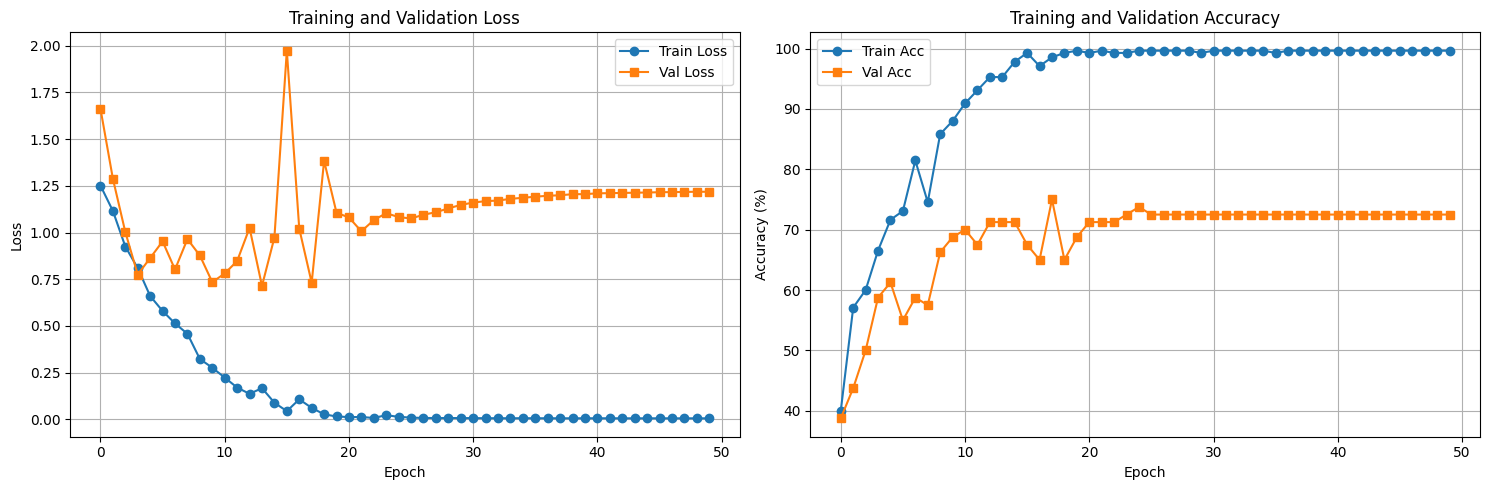


🎉 Training complete!
Best validation accuracy: 75.00%


In [10]:
model = ClassificationModel()

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

trained_model, history = train_classification_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    learning_rate=1e-4 * 2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [11]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def evaluate_model(model, dataloader, device='cuda', class_names=['RPH', 'Blast', 'Rust', 'Aphid'], save_path=None):
    """
    Evaluate model and display classification report and confusion matrix
    
    Args:
        model: PyTorch model to evaluate
        dataloader: DataLoader with test/validation data
        device: 'cuda' or 'cpu'
        class_names: List of class names for display
        save_path: Optional path to save confusion matrix image
    
    Returns:
        dict with predictions, labels, accuracy, and confusion matrix
    """
    model.eval()
    model.to(device)
    
    predictions = []
    ground_truth_labels = []
    
    print("Evaluating model...")
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            images = batch['c12'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            predictions.extend(predicted.cpu().numpy())
            ground_truth_labels.extend(labels.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    ground_truth_labels = np.array(ground_truth_labels)
    
    # Calculate overall accuracy
    accuracy = 100. * np.sum(predictions == ground_truth_labels) / len(ground_truth_labels)
    
    # Print classification report
    print("\n" + "="*60)
    print("CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(ground_truth_labels, predictions, 
                                target_names=class_names, 
                                digits=4))
    
    # Create confusion matrix
    cm = confusion_matrix(ground_truth_labels, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(f'Confusion Matrix\nOverall Accuracy: {accuracy:.2f}%', fontsize=14)
    
    # Add percentage annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            total = cm[i].sum()
            if total > 0:
                percentage = cm[i, j] / total * 100
                plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                        ha='center', va='center', fontsize=9, color='gray')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n✓ Confusion matrix saved to: {save_path}")
    
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print(f"Overall Accuracy: {accuracy:.2f}%")
    print(f"Total Samples: {len(ground_truth_labels)}")
    print("="*60 + "\n")
    
    return {
        'predictions': predictions,
        'labels': ground_truth_labels,
        'accuracy': accuracy,
        'confusion_matrix': cm
    }



FINAL EVALUATION ON BEST MODEL
Evaluating model...


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]



CLASSIFICATION REPORT
              precision    recall  f1-score   support

         RPH     0.6667    0.7000    0.6829        20
       Blast     0.7895    0.7500    0.7692        20
        Rust     1.0000    0.6000    0.7500        20
       Aphid     0.6786    0.9500    0.7917        20

    accuracy                         0.7500        80
   macro avg     0.7837    0.7500    0.7485        80
weighted avg     0.7837    0.7500    0.7485        80


✓ Confusion matrix saved to: satlas_baseline_classification_checkpoints12/final_confusion_matrix.png


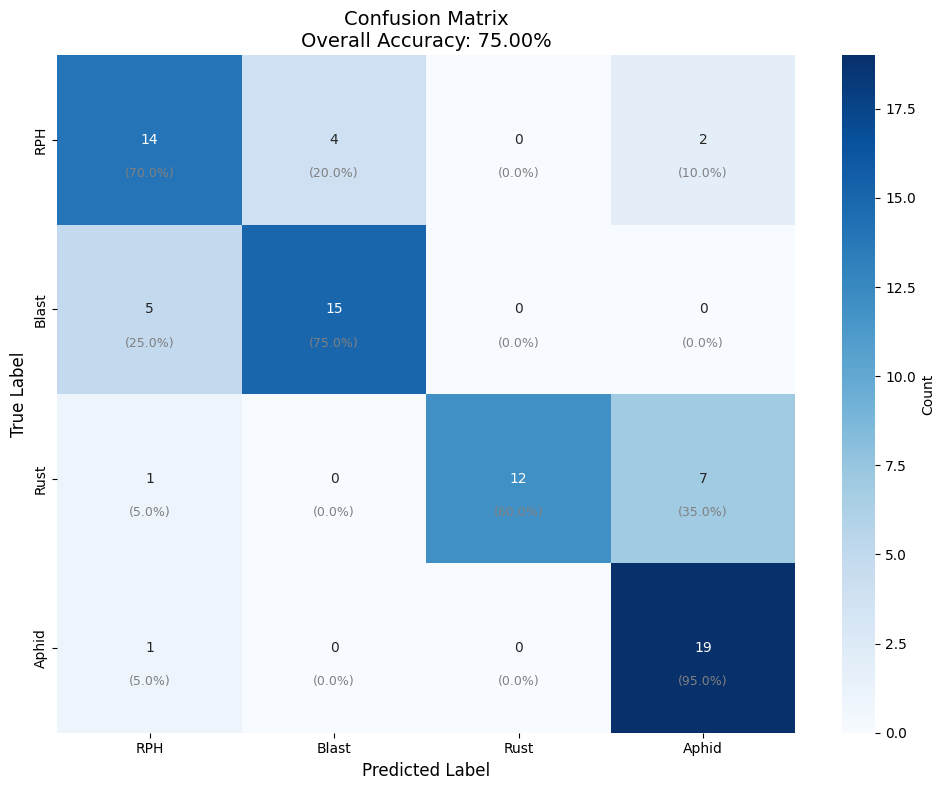


Overall Accuracy: 75.00%
Total Samples: 80



In [12]:
# After training completes, load best model and evaluate
print("\n" + "="*60)
print("FINAL EVALUATION ON BEST MODEL")
print("="*60)

best_model = ClassificationModel(None)
best_model.load_state_dict(torch.load("satlas_baseline_classification_checkpoints12/best_classifier.pth")["model_state_dict"])

final_results = evaluate_model(
    model=best_model,
    dataloader=val_loader,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    class_names=['RPH', 'Blast', 'Rust', 'Aphid'],
    save_path='satlas_baseline_classification_checkpoints12/final_confusion_matrix.png'
)
